## Import Libraries

In [12]:
import numpy as np
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import tensorflow as tf
from tensorflow.keras import backend as K

##  Load the Individual CSV Files

In [13]:
# Define the path to your data directory
data_directory = r'C:\Users\Xande\OneDrive\Documents\Masters Project\Simulated Data\data\imputed_data'

def load_data(directory):
    data = {}
    mask = {}
    labels = {}

    for filename in os.listdir(directory):
        if filename.startswith('imputed_matrix_'):
            id = filename.split('_')[2].split('.')[0]
            data[id] = pd.read_csv(os.path.join(directory, filename)).values
        elif filename.startswith('mask_matrix_'):
            id = filename.split('_')[2].split('.')[0]
            mask[id] = pd.read_csv(os.path.join(directory, filename)).values
        elif filename.startswith('label_'):
            id = filename.split('_')[1].split('.')[0]
            label_df = pd.read_csv(os.path.join(directory, filename))
            if label_df.shape[0] > 0:
                labels[id] = int(label_df.iloc[0, 0])  # Ensure labels are integers
            else:
                print(f"Error reading label for {id}. File content:")
                print(label_df)
    
    return data, mask, labels

# Load the data
data, mask, labels = load_data(data_directory)

## Pad Sequences to Ensure They Have the Same Length

In [14]:
# Find the maximum number of columns in any matrix
max_cols = max(matrix.shape[1] for matrix in data.values())

def pad_matrix(matrix, max_cols):
    """Pad each row of the matrix to have the same number of columns."""
    padding_width = max_cols - matrix.shape[1]
    if padding_width > 0:
        return np.pad(matrix, ((0, 0), (0, padding_width)), mode='constant', constant_values=0)
    return matrix

def pad_sequences_data(data_dict, max_cols):
    padded_sequences = {id: pad_matrix(matrix, max_cols) for id, matrix in data_dict.items()}
    return padded_sequences

# Pad data and mask matrices
padded_data = pad_sequences_data(data, max_cols)
padded_masks = pad_sequences_data(mask, max_cols)

# Convert to numpy arrays
data_array = np.array(list(padded_data.values()))
mask_array = np.array(list(padded_masks.values()))

# Convert labels to numpy array
labels_list = [labels[id] for id in padded_data.keys()]
labels_array = np.array(labels_list)

print("Data shape:", data_array.shape)
print("Mask shape:", mask_array.shape)
print("Labels shape:", labels_array.shape)


Data shape: (5163, 3, 19)
Mask shape: (5163, 3, 19)
Labels shape: (5163,)


In [15]:
import random

# Choose a random person ID
random_id = random.choice(list(data.keys()))

# Get the data, mask, and label for this person
random_data = data[random_id]
random_mask = mask[random_id]
random_label = labels[random_id]

print(f"Random Person ID: {random_id}")
print("Data Matrix:")
print(random_data)
print("\nMask Matrix:")
print(random_mask)
print("\nLabel:", random_label)


Random Person ID: 2147681082
Data Matrix:
[[-2.02665562 -1.9932583  -1.93177687 -1.94543941 -2.05929391 -2.12845672
  -1.86194611 -1.8632061  -1.80672668 -1.90696165 -2.08813705 -1.80438634
  -1.84587998 -1.72683877 -1.70875362 -1.6686819  -1.78907923 -1.68956066
  -1.66915249]
 [ 0.37225833  0.69052751  0.23964617 -0.02557814  0.98227426  1.274021
   1.19445371  2.91841176  3.58147255  4.48323523  2.94493419  2.0299103
   2.62666501  2.67970988  2.49405286  1.99012666  2.20230611  2.0299103
   1.7779472 ]
 [-1.32887532 -1.63385577 -1.0447352  -1.0447352  -0.71891443 -0.53592616
  -1.20688314 -0.27160977  0.22652496 -0.71891443  0.37901519 -0.35293789
  -0.35293789 -0.04795744  0.3180191  -1.02389487 -1.0447352  -1.0447352
   0.44001128]]

Mask Matrix:
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1]
 [1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1]]

Label: 5


In [16]:
# Parameters
input_shape = (max_cols, data_array.shape[2])  # Assuming data is (samples, timesteps, features)

# Split data into training and testing sets
X_train, X_test, y_train, y_test, mask_train, mask_test = train_test_split(
    data_array, labels_array, mask_array, test_size=0.2, random_state=42
)
# Parameters
input_shape = (data_array.shape[1], data_array.shape[2])  # Assuming data is (samples, timesteps, features)

# Hyperparameters and other parameters
RANDOM_SEED = 42
TEST_SIZE = 0.25
EPOCHS = 15
BATCH_SIZE = 32
LEARNING_RATE = 0.002
GRU_UNITS = 100
DENSE_UNITS = 150


# Define GRU Model
def build_gru_model(input_shape, gru_units, dense_units, learning_rate):
    model = Sequential([
        GRU(gru_units, return_sequences=True, input_shape=input_shape),
        GRU(gru_units),
        Dense(dense_units, activation='relu'),
        Dense(1, activation='linear')  # Output layer for ordinal regression
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError(), metrics=['mae'])
    return model

model = build_gru_model(input_shape, GRU_UNITS, DENSE_UNITS, LEARNING_RATE)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data_array, labels_array, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

# Summary of the model
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test MAE: {mae}")

c:\Users\Xande\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_8 (GRU)                     │ (None, 3, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 150)            │        15,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,201 (438.29 KB)

 Trainable params: 112,201 (438.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.3124 - mae: 1.6562 - val_loss: 1.5333 - val_mae: 1.0533
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4584 - mae: 0.9734 - val_loss: 1.4250 - val_mae: 0.9735
Epoch 3/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3183 - mae: 0.9109 - val_loss: 1.4101 - val_mae: 0.9747
Epoch 4/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2565 - mae: 0.9031 - val_loss: 1.4023 - val_mae: 0.9438
Epoch 5/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2228 - mae: 0.8787 - val_loss: 1.4101 - val_mae: 0.9323
Epoch 6/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2025 - mae: 0.8740 - val_loss: 1.6164 - val_mae: 1.0159
Epoch 7/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2840 - mae: 0.9086 - val_loss: 1.3818 - val_mae: 0.9234
Epoch 8/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1548 - mae: 0.8496 - val_loss: 1.4057 - val_mae: 0.9412
Epoch 9/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


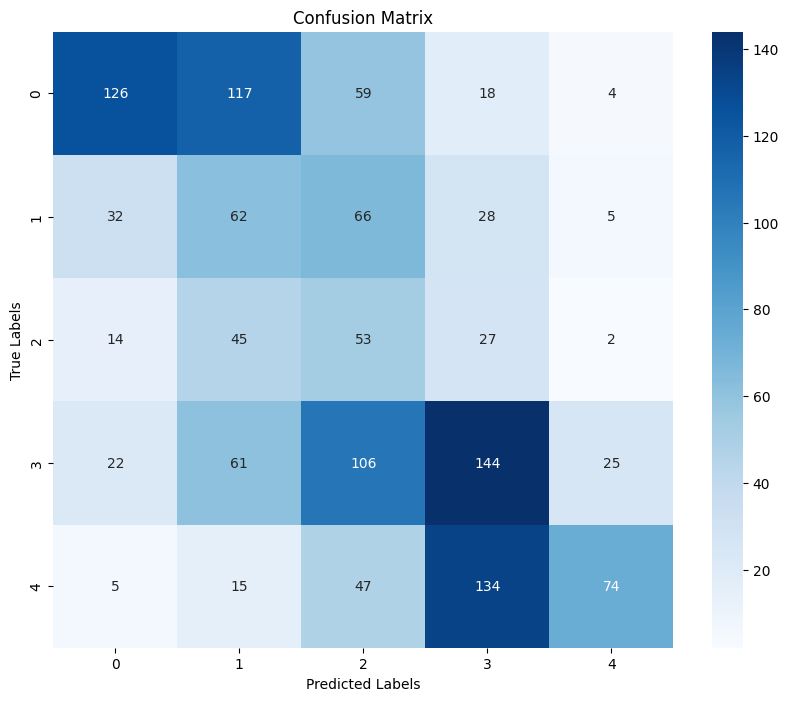

In [17]:
# Generate predictions
y_pred = model.predict(X_test).flatten()

# Convert predictions and actual values to integers
y_pred_int = np.rint(y_pred).astype(int)
y_test_int = np.rint(y_test).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test_int, y_pred_int)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Faulty code

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Dense, Masking, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error

# Define the path to your data directory
data_directory = r'C:\Users\Xande\OneDrive\Documents\Masters Project\Simulated Data\data\imputed_data'

def load_data(directory):
    data = {}
    mask = {}
    labels = {}

    for filename in os.listdir(directory):
        if filename.startswith('imputed_matrix_'):
            id = filename.split('_')[2].split('.')[0]
            data[id] = pd.read_csv(os.path.join(directory, filename)).values
        elif filename.startswith('mask_matrix_'):
            id = filename.split('_')[2].split('.')[0]
            mask[id] = pd.read_csv(os.path.join(directory, filename)).values
        elif filename.startswith('label_'):
            id = filename.split('_')[1].split('.')[0]
            label_df = pd.read_csv(os.path.join(directory, filename))
            if label_df.shape[0] > 0:
                labels[id] = int(label_df.iloc[0, 0])  # Ensure labels are integers
            else:
                print(f"Error reading label for {id}. File content:")
                print(label_df)
    
    return data, mask, labels

# Load the data
data, mask, labels = load_data(data_directory)

# Find the maximum number of columns in any matrix
max_cols = max(matrix.shape[1] for matrix in data.values())

def pad_matrix(matrix, max_cols):
    """Pad each row of the matrix to have the same number of columns."""
    padding_width = max_cols - matrix.shape[1]
    if padding_width > 0:
        return np.pad(matrix, ((0, 0), (0, padding_width)), mode='constant', constant_values=0)
    return matrix

def pad_sequences_data(data_dict, max_cols):
    padded_sequences = {id: pad_matrix(matrix, max_cols) for id, matrix in data_dict.items()}
    return padded_sequences

# Pad data and mask matrices
padded_data = pad_sequences_data(data, max_cols)
padded_masks = pad_sequences_data(mask, max_cols)

# Convert to numpy arrays
data_array = np.array(list(padded_data.values()))
mask_array = np.array(list(padded_masks.values()))

# Convert labels to numpy array
labels_list = [labels[id] for id in padded_data.keys()]
labels_array = np.array(labels_list)

print("Data shape:", data_array.shape)
print("Mask shape:", mask_array.shape)
print("Labels shape:", labels_array.shape)

# Parameters
input_shape = (max_cols, data_array.shape[2])  # Assuming data is (samples, timesteps, features)

# Split data into training and testing sets
X_train, X_test, y_train, y_test, mask_train, mask_test = train_test_split(
    data_array, labels_array, mask_array, test_size=0.2, random_state=42
)
# Parameters
input_shape = (data_array.shape[1], data_array.shape[2])  # Assuming data is (samples, timesteps, features)

# Hyperparameters and other parameters
RANDOM_SEED = 42
TEST_SIZE = 0.25
EPOCHS = 15
BATCH_SIZE = 32
LEARNING_RATE = 0.002
GRU_UNITS = 100
DENSE_UNITS = 150


# Define GRU Model
def build_gru_model(input_shape, gru_units, dense_units, learning_rate):
    model = Sequential([
        GRU(gru_units, return_sequences=True, input_shape=input_shape),
        GRU(gru_units),
        Dense(dense_units, activation='relu'),
        Dense(1, activation='linear')  # Output layer for ordinal regression
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError(), metrics=['mae'])
    return model

model = build_gru_model(input_shape, GRU_UNITS, DENSE_UNITS, LEARNING_RATE)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data_array, labels_array, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

# Summary of the model
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test MAE: {mae}")

Data shape: (5163, 3, 19)
Mask shape: (5163, 3, 19)
Labels shape: (5163,)


c:\Users\Xande\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 3, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │        15,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,201 (438.29 KB)

 Trainable params: 112,201 (438.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 4.0425 - mae: 1.6215 - val_loss: 1.4389 - val_mae: 0.9550
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3901 - mae: 0.9462 - val_loss: 1.5911 - val_mae: 0.9817
Epoch 3/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3095 - mae: 0.9134 - val_loss: 1.3583 - val_mae: 0.9375
Epoch 4/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2657 - mae: 0.8936 - val_loss: 1.4187 - val_mae: 0.9886
Epoch 5/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2641 - mae: 0.9041 - val_loss: 1.4362 - val_mae: 0.9586
Epoch 6/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2850 - mae: 0.9092 - val_loss: 1.4044 - val_mae: 0.9519
Epoch 7/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1938 - mae: 0.8700 - val_loss: 1.3518 - val_mae: 0.9229
Epoch 8/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1285 - mae: 0.8308 - val_loss: 1.4219 - val_mae: 0.9483
Epoch 9/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


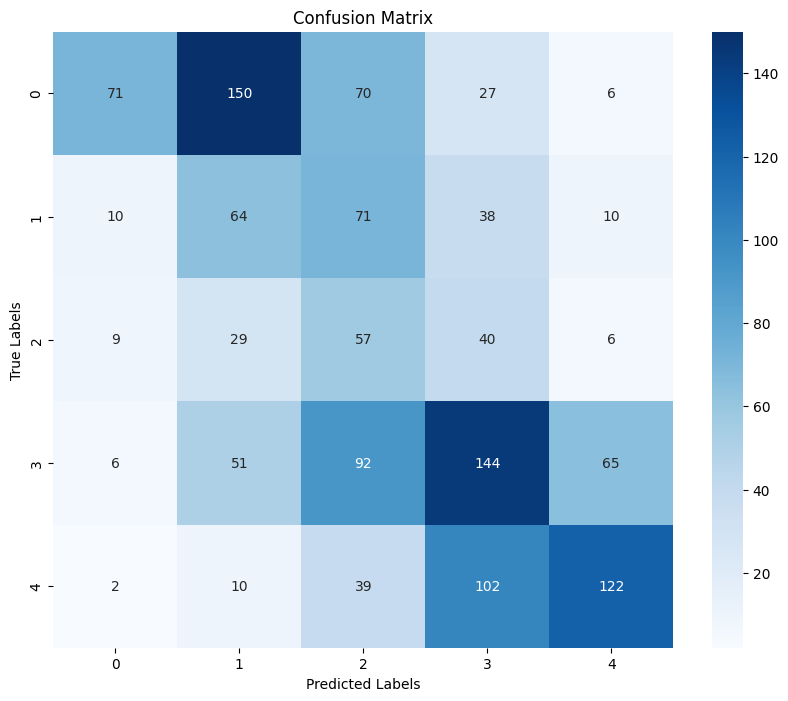

In [2]:
# Generate predictions
y_pred = model.predict(X_test).flatten()

# Convert predictions and actual values to integers
y_pred_int = np.rint(y_pred).astype(int)
y_test_int = np.rint(y_test).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test_int, y_pred_int)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()